<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/Comparison_Merge_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 1-2. Terminology

In [6]:
from dataclasses import dataclass
@dataclass
class Notation:
    y1: str = "K-Intensive"
    y2: str = "Inverted K-Intensive"
    y3: str = "L-Intensive"

note = Notation()

# Comparison

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# ======================
# 0. Global config
# ======================
SEED = 44
ep = 100        # pretrain epochs on K^3
probe_ep = 100  # TL tasks
dense_num = [8, 8, 8, 4]

In [9]:
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

# ======================
# 1. Data
# ======================
n = 1000
noise_scale = 0.05

# K-intensive: K ~ U(0,1), L = 0
K = np.random.rand(n, 1)
L0 = np.zeros((n, 1))
X_K = np.hstack([K, L0])

# L-intensive: K = 0, L ~ U(0,1)
K0 = np.zeros((n, 1))
L = np.random.rand(n, 1)
X_L = np.hstack([K0, L])

# Targets with noise
y1 = K**3  + np.random.normal(0, noise_scale, size=(n, 1))   #  K^3
y2 = -K**3 + np.random.normal(0, noise_scale, size=(n, 1))   # -K^3
y3 = L**3  + np.random.normal(0, noise_scale, size=(n, 1))   #  L^3

# Cast to float32 for Keras
X_K = X_K.astype("float32")
X_L = X_L.astype("float32")
y1  = y1.astype("float32")
y2  = y2.astype("float32")
y3  = y3.astype("float32")

# For plotting: sort by K and by L
K_1d = X_K[:, 0]
order_K = np.argsort(K_1d)
K_sorted = K_1d[order_K]
y1_sorted = y1[order_K, 0]
y2_sorted = y2[order_K, 0]

L_1d = X_L[:, 1]
order_L = np.argsort(L_1d)
L_sorted = L_1d[order_L]
y3_sorted = y3[order_L, 0]


# ======================
# 2. Model builders
# ======================
def build_full_model():
    inp = Input(shape=(2,), name='input_full')
    h1 = Dense(dense_num[0], activation='relu',
               kernel_initializer='he_normal', name='dense8_1')(inp)
    h2 = Dense(dense_num[1], activation='relu',
               kernel_initializer='he_normal', name='dense8_2')(h1)
    h3 = Dense(dense_num[2], activation='relu',
               kernel_initializer='he_normal', name='dense8_3')(h2)
    h4 = Dense(dense_num[3], activation='relu',
               kernel_initializer='he_normal', name='dense8_4')(h3)
    out = Dense(1, activation='linear', name='out')(h4)

    model = Model(inputs=inp, outputs=out, name='FullModel_8_8_8_4_1')
    model.compile(optimizer='adam', loss='mse')
    return model


def build_probe_at(backbone_model, stop_layer_name, head_name):
    """Attach a linear head on top of frozen backbone at given layer."""
    frozen_out = backbone_model.get_layer(stop_layer_name).output
    head = Dense(1, activation='linear', name=head_name)(frozen_out)
    probe = Model(inputs=backbone_model.input,
                  outputs=head,
                  name=f"Probe_{head_name}")
    probe.compile(optimizer='adam', loss='mse')
    return probe


# ======================
# 3. Pretrain on K^3 (y1)
# ======================
full_model = build_full_model()
full_model.fit(X_K, y1, epochs=ep, batch_size=32, verbose=0)
full_model.summary()

# Backbone: clone + copy weights + freeze hidden layers
backbone = tf.keras.models.clone_model(full_model)
_ = backbone(tf.zeros((1, 2)))  # build
backbone.set_weights(full_model.get_weights())

for lyr in backbone.layers:
    if lyr.name.startswith('dense8_'):
        lyr.trainable = False


# ======================
# 4. Build probes (for each layer, we build two heads)
#    - Task Kneg: X_K -> y2  (−K^3)
#    - Task Lcube: X_L -> y3 ( L^3)
# ======================
layer_names = [
    #"input_full",
    "dense8_1",
    "dense8_2",
    "dense8_3",
    "dense8_4",
]

probes_Kneg = {}
probes_Lcube = {}

for lname in layer_names:
    probes_Kneg[lname] = build_probe_at(backbone, lname, f"headK_{lname}")
    probes_Lcube[lname] = build_probe_at(backbone, lname, f"headL_{lname}")


# ======================
# 5. Train probes on their tasks
# ======================
for lname in layer_names:
    print(f"\n=== Training probes at layer: {lname} ===")
    print("Task Kneg: X_K -> -K^3")
    probes_Kneg[lname].fit(X_K, y2, epochs=probe_ep, batch_size=32, verbose=0)

    print("Task Lcube: X_L -> L^3")
    probes_Lcube[lname].fit(X_L, y3, epochs=probe_ep, batch_size=32, verbose=0)


# ======================
# 6. Plotting utilities
# ======================
def plot_1d_probe_pair(model_K, model_L,
                       X_K, y2, order_K, K_sorted, y2_sorted,
                       X_L, y3, order_L, L_sorted, y3_sorted,
                       layer_name):
    """Side-by-side plots for -K^3 and L^3 at the same layer."""

    # ----- architecture string: 2 -> 8 -> 1, 2 -> 8 -> 8 -> 1, ... -----
    def arch_from_layer(name):
        if name == "input_full":
            return "2 → 1"
        if name.startswith("dense8_"):
            idx = int(name.split("_")[1])          # 1,2,3,4
            hidden = " → ".join(str(dense_num[i])  # dense_num는 전역 리스트
                                 for i in range(idx))
            return f"2 → {hidden} → 1"
        return name

    arch_str = arch_from_layer(layer_name)

    # ---- Task 1: -K^3 ----
    y_hat_K = model_K.predict(X_K, verbose=0)[:, 0]
    y_hat_K_sorted = y_hat_K[order_K]
    mse_K = np.mean((y_hat_K - y2[:, 0])**2)

    # ---- Task 2: L^3 ----
    y_hat_L = model_L.predict(X_L, verbose=0)[:, 0]
    y_hat_L_sorted = y_hat_L[order_L]
    mse_L = np.mean((y_hat_L - y3[:, 0])**2)

    print(f"[{layer_name}] ({arch_str}) -K^3 MSE: {mse_K:.6f}")
    print(f"[{layer_name}] ({arch_str})  L^3 MSE: {mse_L:.6f}")

    # ---- Side-by-side figure: 세로 길이 키움 ----
    fig, axes = plt.subplots(1, 2, figsize=(11, 5.5), sharey=True)
    fig.suptitle(f"{arch_str}", fontsize=14)

    # (a) -K^3
    ax1 = axes[0]
    ax1.scatter(K_sorted, y2_sorted,
                s=8, alpha=0.3, c='0.6', label='data: -K^3')
    ax1.plot(K_sorted, y_hat_K_sorted,
             'k-', linewidth=2, label='probe pred')
    ax1.set_xlabel('K')
    ax1.set_ylabel('prediction')
    ax1.set_title(f"-K^3  (MSE={mse_K:.4f})")
    ax1.grid(True, color='0.8', linestyle=':')
    ax1.legend()

    # (b) L^3
    ax2 = axes[1]
    ax2.scatter(L_sorted, y3_sorted,
                s=8, alpha=0.3, c='0.6', label='data: L^3')
    ax2.plot(L_sorted, y_hat_L_sorted,
             'k-', linewidth=2, label='probe pred')
    ax2.set_xlabel('L')
    ax2.set_title(f"L^3  (MSE={mse_L:.4f})")
    ax2.grid(True, color='0.8', linestyle=':')
    ax2.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()


Model: "FullModel_8_8_8_4_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_full (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense8_1 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense8_2 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense8_3 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense8_4 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 629 (2.46 KB)

 Trainable params: 209 (836.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 420 (1.64 KB)


=== Training probes at layer: dense8_1 ===
Task Kneg: X_K -> -K^3
Task Lcube: X_L -> L^3

=== Training probes at layer: dense8_2 ===
Task Kneg: X_K -> -K^3
Task Lcube: X_L -> L^3

=== Training probes at layer: dense8_3 ===
Task Kneg: X_K -> -K^3
Task Lcube: X_L -> L^3

=== Training probes at layer: dense8_4 ===
Task Kneg: X_K -> -K^3
Task Lcube: X_L -> L^3



######## Layer: dense8_1 ########
[dense8_1] (2 → 8 → 1) -K^3 MSE: 0.014721
[dense8_1] (2 → 8 → 1)  L^3 MSE: 0.006723


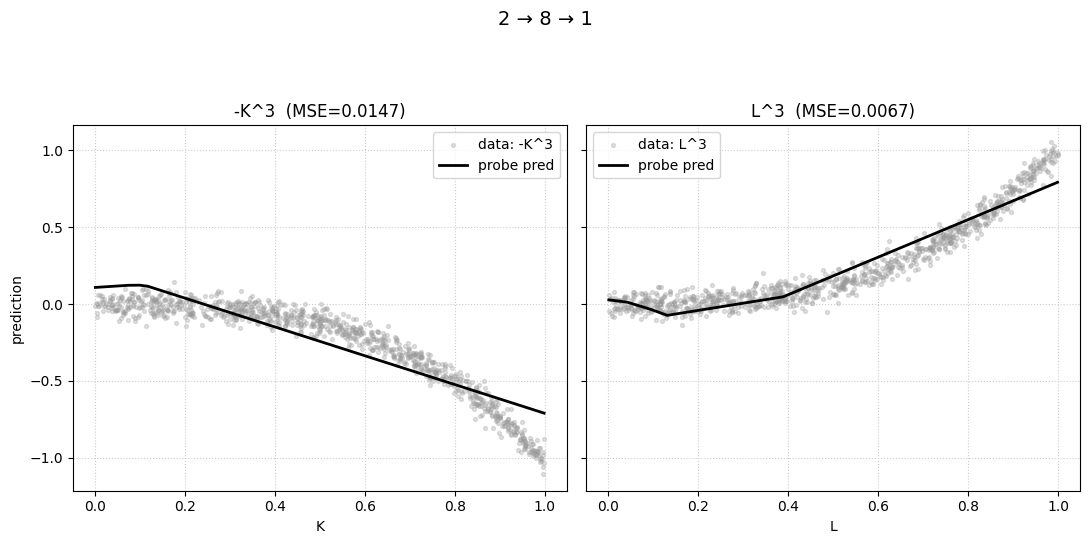


######## Layer: dense8_2 ########
[dense8_2] (2 → 8 → 8 → 1) -K^3 MSE: 0.013799
[dense8_2] (2 → 8 → 8 → 1)  L^3 MSE: 0.012386


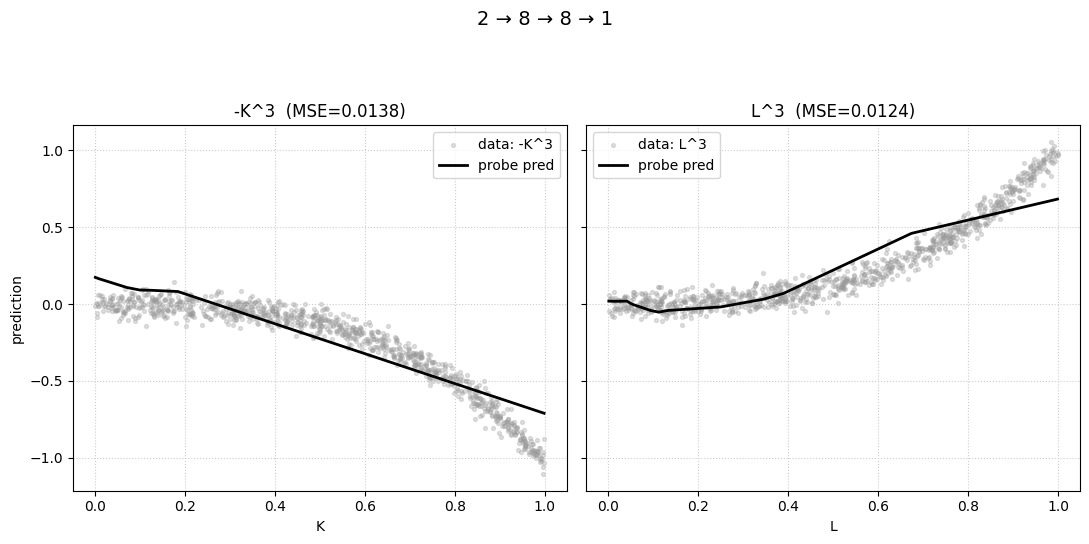


######## Layer: dense8_3 ########
[dense8_3] (2 → 8 → 8 → 8 → 1) -K^3 MSE: 0.013141
[dense8_3] (2 → 8 → 8 → 8 → 1)  L^3 MSE: 0.012069


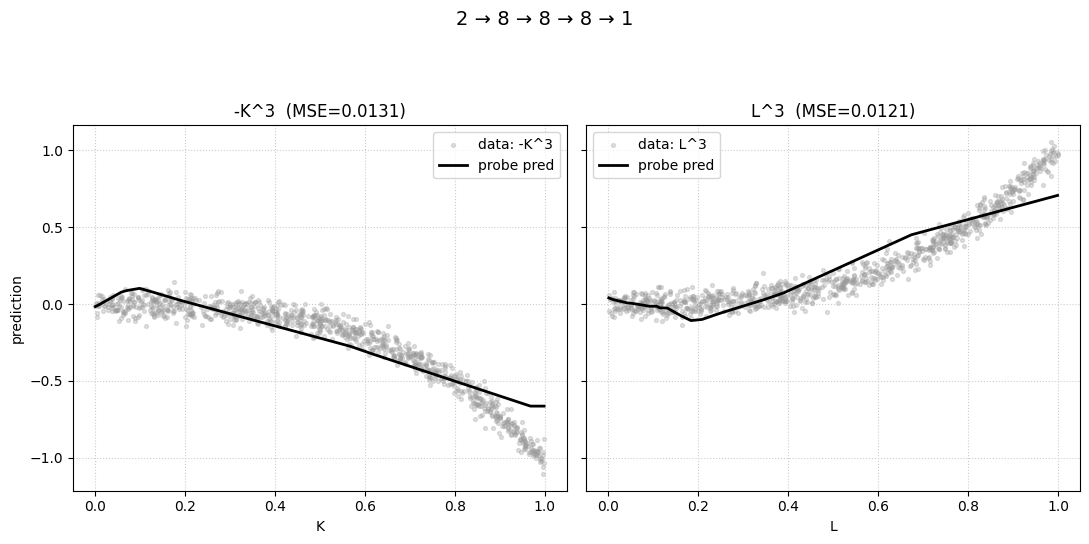


######## Layer: dense8_4 ########
[dense8_4] (2 → 8 → 8 → 8 → 4 → 1) -K^3 MSE: 0.005877
[dense8_4] (2 → 8 → 8 → 8 → 4 → 1)  L^3 MSE: 0.070095


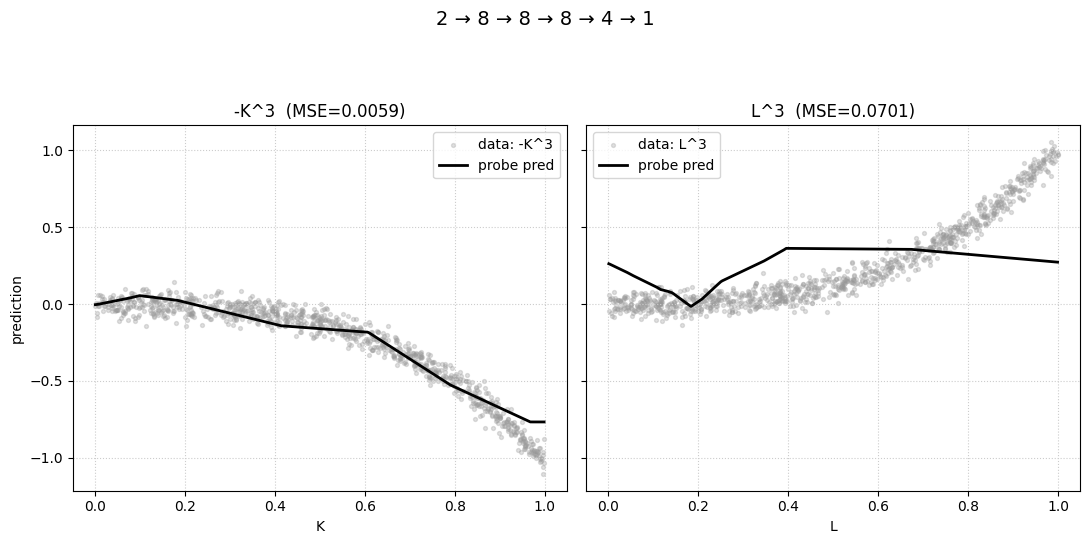

In [10]:
# ======================
# 7. Compare per layer (side-by-side)
# ======================
for lname in layer_names:
    print(f"\n######## Layer: {lname} ########")

    plot_1d_probe_pair(
        model_K      = probes_Kneg[lname],   # -K^3 task
        model_L      = probes_Lcube[lname],  #  L^3 task
        X_K          = X_K,
        y2           = y2,
        order_K      = order_K,
        K_sorted     = K_sorted,
        y2_sorted    = y2_sorted,
        X_L          = X_L,
        y3           = y3,
        order_L      = order_L,
        L_sorted     = L_sorted,
        y3_sorted    = y3_sorted,
        layer_name   = lname,
    )


학습이 진행될수록  -K^3 은 더 잘 맞고 L^3은 잘 맞지 않는다.

L^3(이종산업)에 대한 학습은 특히 transfer learning을 진행하는 layer의 노드 수에 큰 영향을 받는다.

# Flow Visualization

In [4]:
import os
import matplotlib.style as style
style.use('tableau-colorblind10')

SAVE_SPLIT = False
outdir = "."

# ---------- ReLU keep prob & feature path utils ----------

def get_relu_keep_probs_aligned(model, X_batch):
    X = tf.identity(X_batch)
    masks, layer_indices = [], []

    for idx, layer in enumerate(model.layers):
        ws = layer.get_weights()
        if len(ws) == 0:
            # no weights -> just propagate X
            try:
                X = layer(X)
            except Exception:
                act = getattr(layer, "activation", None)
                if act is not None:
                    X = act(X)
            continue

        W_tf = tf.convert_to_tensor(ws[0], dtype=tf.float32)
        z = tf.matmul(X, W_tf)
        if len(ws) > 1:
            b_tf = tf.convert_to_tensor(ws[1], dtype=tf.float32)
            z = z + b_tf

        act = getattr(layer, "activation", None)
        # keep prob (mean of ReLU mask) only for ReLU layers
        masks.append(
            tf.reduce_mean(tf.cast(z > 0.0, tf.float32), axis=0).numpy()
            if (act == tf.keras.activations.relu) else None
        )
        layer_indices.append(idx)

        try:
            X = layer(X)
        except Exception:
            X = act(z) if act is not None else z

    return masks, layer_indices


def compute_forward_path(
     Ws, Bs, dense_layer_indices, layer_idxs,
     masks, include_bias=False, onehot=True
):
    N = 1 if onehot else 11
    kpath = [[None for _ in range(N)]  for _ in range(N)]

    for ktrial in range(N):
        e = np.zeros(Ws[0].shape[0], dtype=np.float64)
        e[0] = 0.1 * ktrial  # first input dimension

        for ltrial in range(N):
            if not onehot:
                e[1] = 0.1 * (ltrial)  # second input dimension도 변화
            path, v = [e.copy()], None

            for k, W in enumerate(Ws):
                if v is None:
                    # first weight-layer: contribution e @ W
                    v = e @ W                      # shape (out_dim,)
                else:
                    # find mask position for prev_layer_idx inside dense_layer_indices
                    pos = dense_layer_indices.index(layer_idxs[k-1])
                    # ReLU layer면 keep prob mask 적용, 아니면 그대로
                    v *= masks[pos] if (masks[pos] is not None and masks[pos].all()) else 1
                    v = v @ W

                if include_bias and Bs[k] is not None:
                    v = v + Bs[k]
                path.append(v.copy())

            kpath[ktrial][ltrial] = path

    # ---- 여기서부터가 중요: path 전체 길이(입력 + 모든 Dense + Output)를 그대로 사용 ----
    num_layers = len(kpath[0][0])           # e, h1, h2, h3, h4, out → 6
    result = [[None for _ in range(num_layers)] for _ in range(N)]
    for k in range(N):
        for lyr in range(num_layers):
            result[k][lyr] = sum([kpath[k][l][lyr] for l in range(N)]) / N

    return result


def layer_stats(path):
    layer_L1 = [np.sum(np.abs(x)) for x in path]
    total = sum(layer_L1) if sum(layer_L1) != 0 else 1.0
    layer_pct = [x / total for x in layer_L1]
    layer_units = [x.shape[0] for x in path]
    return layer_L1, layer_pct, layer_units


def feature_path(_model, X_batch, include_bias=False, onehot=True):
    masks, dense_layer_indices = get_relu_keep_probs_aligned(_model, X_batch)
    Ws, Bs, layer_idxs = [], [], []
    for idx, layer in enumerate(_model.layers):
        ws = layer.get_weights()
        if len(ws) == 0:
            continue
        Ws.append(ws[0].astype(np.float64))
        Bs.append((ws[1].astype(np.float64) if (include_bias and len(ws) > 1) else None))
        layer_idxs.append(idx)

    if len(Ws) == 0:
        raise ValueError("Model has no weight-containing layers.")

    kpaths = compute_forward_path(
        Ws, Bs, dense_layer_indices,
        layer_idxs, masks, include_bias, onehot)

    return {
        "paths": kpaths,
        "layer_idxs": layer_idxs,
        "masks": masks,
        "dense_layer_indices": dense_layer_indices
    }

# ---------- plotting ----------

marker = ["x", "."]
order_ = ['Input', 'Dense 1', 'Dense 2', 'Dense 3', 'Dense 4', 'Output']

input_str = lambda t, f: f"K={f[t][0][0]:.1f}"


def plot_feature_path(model, X_batch, vmin=-3, vmax=3,
                      cmap='gray', caption='', folder='latent_feature',
                      filename='gradual_vectors'):
    info = feature_path(model, X_batch, onehot=False)
    feat_vecs = info['paths']           # shape: [N_trial, 5, vec_dim]
    rows, cols = len(feat_vecs), len(feat_vecs[0])

    # print simple feature norms (L1) for first trial
    path_example = feat_vecs[0]
    layer_L1, layer_pct, layer_units = layer_stats(path_example)
    print(f"\n[Feature norms] {caption if caption else filename}")
    for k in range(cols):
        print(f"  {order_[k]}: L1 = {layer_L1[k]:.4f}, "
              f"share = {layer_pct[k]*100:5.2f}%, "
              f"units = {layer_units[k]}")

    layer_titles = [
        f"{order_[k]}\n(# = {feat_vecs[0][k].shape[0]})\n"
        for k in range(cols)
    ]

    # subsample inputs for visualization
    temp = feat_vecs[::3].copy()
    fig, axes = plt.subplots(len(temp), cols,
                             figsize=(cols + 1, len(temp) * 2),
                             squeeze=False)
    for k in range(cols):
        axes[0][k].set_title(layer_titles[k], fontsize=12)

    for t in range(len(temp)):
        axes[t][0].set_ylabel(input_str(t, temp), fontsize=12)
        for k, v in enumerate(temp[t]):
            ax = axes[t][k]
            ax.set_yticks([])
            ax.set_xticks([])
            ax.imshow(v[np.newaxis, :].T,
                      aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
        # show first unit value of last layer
        v_last = temp[t][-1]
        axes[t][-1].text(0, 0, f"{v_last[0]:.2f}",
                         ha="center", va="center",
                         color='white' if v_last[0] < 0 else 'black')

    cbar = fig.colorbar(
        plt.cm.ScalarMappable(
            norm=plt.cm.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap),
        ax=axes.ravel().tolist(), orientation='vertical',
        fraction=0.12, pad=0.02, aspect=20)
    cbar.set_label("Value")

    plt.suptitle(caption, y=1.02)
    if SAVE_SPLIT:
        os.makedirs(f"{outdir}/{folder}", exist_ok=True)
        plt.savefig(f"{outdir}/{folder}/{filename}.png",
                    dpi=250, bbox_inches="tight")
    else:
        plt.show()




[Feature norms] Mean of 11 trials on K-Intensive
  Input: L1 = 0.5000, share =  1.20%, units = 2
  Dense 1: L1 = 5.0066, share = 12.04%, units = 8
  Dense 2: L1 = 6.8930, share = 16.58%, units = 8
  Dense 3: L1 = 14.3832, share = 34.59%, units = 8
  Dense 4: L1 = 7.8472, share = 18.87%, units = 4
  Output: L1 = 6.9542, share = 16.72%, units = 1


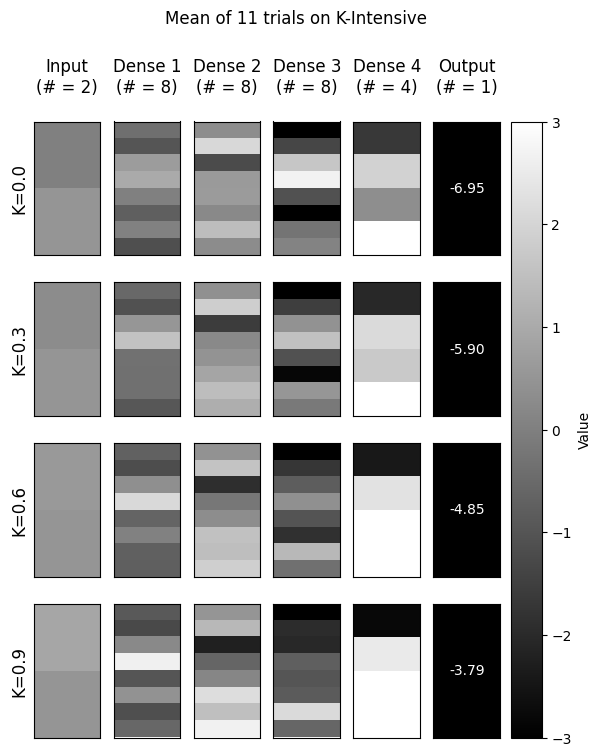


[Feature norms] Transfer on Inverted K-Intensive
  Input: L1 = 0.5000, share =  1.39%, units = 2
  Dense 1: L1 = 5.0066, share = 13.93%, units = 8
  Dense 2: L1 = 6.8930, share = 19.18%, units = 8
  Dense 3: L1 = 14.3832, share = 40.02%, units = 8
  Dense 4: L1 = 7.8472, share = 21.83%, units = 4
  Output: L1 = 1.3129, share =  3.65%, units = 1


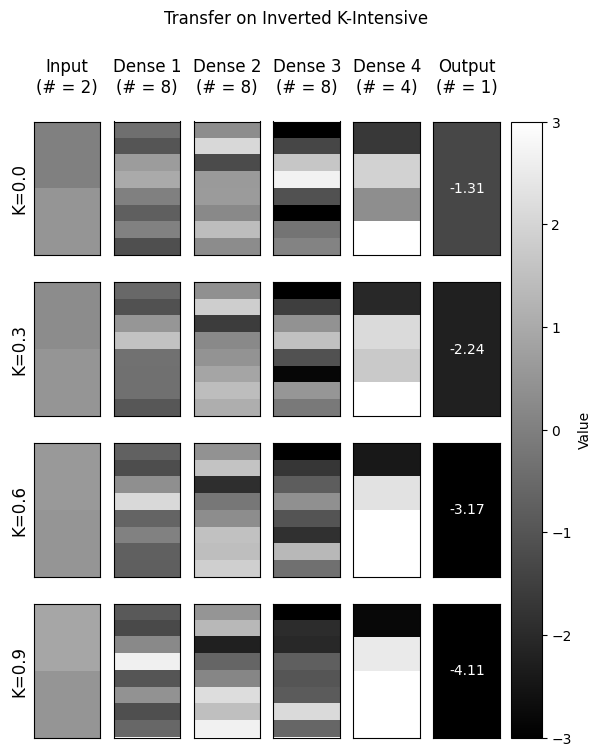


[Feature norms] Transfer on L-Intensive
  Input: L1 = 0.5000, share =  1.32%, units = 2
  Dense 1: L1 = 5.0066, share = 13.20%, units = 8
  Dense 2: L1 = 6.8930, share = 18.17%, units = 8
  Dense 3: L1 = 14.3832, share = 37.92%, units = 8
  Dense 4: L1 = 7.8472, share = 20.69%, units = 4
  Output: L1 = 3.2971, share =  8.69%, units = 1


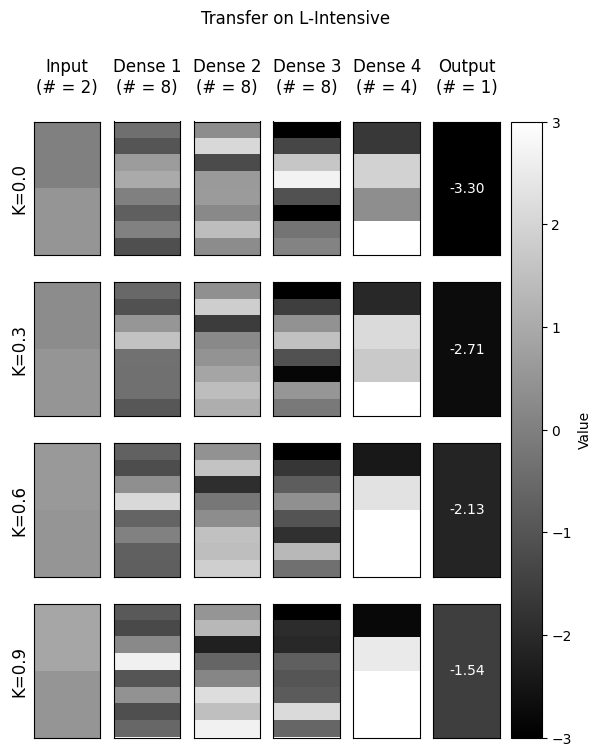

In [5]:
# ---------- 모델 alias 지정 & 실행 예시 ----------

# 원래 K^3로 학습된 전체 모델
model = full_model

# 예시로: 마지막 레이어에서 TL한 -K^3 / L^3 probe 사용
# (원하면 다른 레이어 이름으로 바꿔도 됨: "input_full", "dense8_1" 등)
model_tf_1layer_y2 = probes_Kneg["dense8_4"]
model_tf_1layer_y3 = probes_Lcube["dense8_4"]

# 1) Original model on K^3
plot_feature_path(
    model, X_batch=X_K,
    caption=f"Mean of 11 trials on {note.y1}",
    folder='latent_feature', filename='origin'
)

# 2) TL model on -K^3
plot_feature_path(
    model_tf_1layer_y2, X_batch=X_K,
    caption=f"Transfer on {note.y2}",
    folder='latent_feature',
    filename=f'transferlearn_{note.y2}'
)

# 3) TL model on L^3
plot_feature_path(
    model_tf_1layer_y3, X_batch=X_L,
    caption=f"Transfer on {note.y3}",
    folder='latent_feature',
    filename=f'transferlearn_{note.y3}'
)
